In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis

data = pd.read_excel('liquidity_challenge.xlsx')
data

,property_id,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,...,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,069c4d09-1f4e-4451-bf9f-23130537bb37,1,96,apartment,120.0,2.5,2.0,-2.900368e+18,-7946976479905633280,1.0,...,1,0,0,0,0,0,0,0,0,0
1,0a4c5851-88ae-4d33-8fb7-f7d50ca85389,0,37,apartment,82.0,2.0,2.0,8.261012e+18,1284474136562356992,2.0,...,1,0,0,0,0,0,1,1,0,0
2,9d31a760-0ffd-44df-b77e-28fe6e1b019d,1,88,apartment,84.0,2.0,2.0,1.657070e+18,-3834970849644356096,1.0,...,0,0,0,0,0,0,0,0,0,0
3,fb141128-2a00-4117-929d-ca7ef507d2ab,1,58,apartment,92.0,2.0,2.0,-2.900368e+18,-7946976479905633280,0.0,...,1,0,0,0,0,0,1,0,0,0
4,b334cf18-5c23-4914-947a-d545c439845f,0,95,apartment,55.0,1.0,1.0,8.261012e+18,377027056504647872,1.0,...,1,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,2efe418d-fed8-4680-9e42-16960ac8995e,1,63,apartment,60.0,1.0,1.0,6.474342e+18,377027056504647872,1.6,...,0,0,0,0,0,0,0,0,0,0
4736,0633a509-a82b-4f99-ac4a-9cf3f2a36794,0,47,house,208.0,2.0,3.0,6.474342e+18,377027056504647872,2.0,...,0,1,0,0,0,0,1,0,0,1
4737,12a38011-9f85-4ef4-ae63-c8c2c5191e18,1,15,apartment,60.0,1.0,3.0,8.261012e+18,3394197719927815168,1.6,...,0,0,0,0,0,0,0,0,0,0
4738,14e7d7d1-de1f-4124-bef1-8687f1cb5818,1,49,house,302.0,3.0,4.0,6.474342e+18,377027056504647872,2.0,...,0,1,0,0,0,0,0,0,0,1


In [59]:
for col in data.columns:
    nulls =  data[col].isna().sum()
    if nulls >0:
        print(f'{col} has:',nulls, 'nulls')

num_bathrooms has: 95 nulls
num_bedrooms has: 94 nulls
marketplace_hash has: 95 nulls
num_parking_lots has: 95 nulls


In this case if there were more nulls, I would probably input the mean into the nulls so the distribution wouldn't change. I am just going to drop the rows.

In [60]:
# Dropping nulls
data.dropna(inplace=True)

# Dropping id
data.drop('property_id', axis = 1, inplace = True)
data.head()

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,first_price,...,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,1,96,apartment,120.0,2.5,2.0,-2.900368e+18,-7946976479905633280,1.0,4100000.0,...,1,0,0,0,0,0,0,0,0,0
1,0,37,apartment,82.0,2.0,2.0,8.261012e+18,1284474136562356992,2.0,4900000.0,...,1,0,0,0,0,0,1,1,0,0
2,1,88,apartment,84.0,2.0,2.0,1.657070e+18,-3834970849644356096,1.0,2782696.0,...,0,0,0,0,0,0,0,0,0,0
3,1,58,apartment,92.0,2.0,2.0,-2.900368e+18,-7946976479905633280,0.0,5280000.0,...,1,0,0,0,0,0,1,0,0,0
4,0,95,apartment,55.0,1.0,1.0,8.261012e+18,377027056504647872,1.0,3250000.0,...,1,1,1,0,1,0,1,1,0,0


### Dropping market hash and seller hash
I will also drop market and seller hash as I'm not sure what they mean. They could probably be ids from market and seller, if needed they could be updated to lower numerical values.

In [61]:
data.drop(['marketplace_hash', 'seller_hash'], axis = 1, inplace = True)

### Encoding
Now I will encode property type

In [62]:
dict_aux = {"apartment" : 0,
            "house": 1}
data['property_type'].replace(dict_aux, inplace = True)

In [63]:
# Feature engieneering
data['First_year'] = data['first_observed_date'].dt.year
data['First_month'] = data['first_observed_date'].dt.month
data['First_day'] = data['first_observed_date'].dt.day

data['Last_year'] = data['last_observed_date'].dt.year
data['Last_month'] = data['last_observed_date'].dt.month
data['Last_day'] = data['last_observed_date'].dt.day

dict_aux = { 0: True,
            1: False}
data['event'].replace(dict_aux, inplace = True)


data['price_change'] = 100*((data['last_price'] - data['first_price']) / data['last_price'])
data.drop(['first_observed_date', 'last_observed_date', 'last_price'], axis = 1, inplace = True)
data

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,num_parking_lots,first_price,longitude,latitude,...,has_terrace,has_visitors_parking,has_washing_area,First_year,First_month,First_day,Last_year,Last_month,Last_day,price_change
0,False,96,0,120.0,2.5,2.0,1.0,4100000.0,-99.197758,19.377609,...,0,0,0,2023,6,4,2023,9,9,0.0
1,True,37,0,82.0,2.0,2.0,2.0,4900000.0,-99.183100,19.402272,...,1,0,0,2023,9,9,2023,10,9,0.0
2,False,88,0,84.0,2.0,2.0,1.0,2782696.0,-99.114488,19.399742,...,0,0,0,2023,7,5,2023,10,2,0.0
3,False,58,0,92.0,2.0,2.0,0.0,5280000.0,-99.176732,19.395337,...,0,0,0,2023,4,13,2023,6,11,0.0
4,True,95,0,55.0,1.0,1.0,1.0,3250000.0,-99.145629,19.433646,...,1,0,0,2023,7,12,2023,10,9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,False,63,0,60.0,1.0,1.0,1.6,2900000.0,-99.167840,19.431940,...,0,0,0,2023,6,19,2023,8,21,0.0
4736,True,47,1,208.0,2.0,3.0,2.0,5300000.0,-99.122442,19.274504,...,0,0,1,2023,8,29,2023,10,9,0.0
4737,False,15,0,60.0,1.0,3.0,1.6,1750000.0,-99.141260,19.467090,...,0,0,0,2023,6,4,2023,6,19,0.0
4738,False,49,1,302.0,3.0,4.0,2.0,13900000.0,-99.205880,19.344100,...,0,0,1,2023,7,3,2023,8,21,0.0


In [64]:
print(data['First_year'].value_counts())
data['Last_year'].value_counts()

# As there is no change in the year, I will drop it
data.drop(['First_year', 'Last_year'], axis = 1, inplace = True)

First_year
2023    4370
Name: count, dtype: int64


Now we have all our dataset encoded as numeric, so let start spliting it 

In [80]:
from sklearn.model_selection import train_test_split
predictors = [c for c in data.columns if c != 'event' and c != 'time2event']
X = data[predictors]
y = data[['event', 'time2event']].to_numpy()

#List of tuples
aux = [(e1,e2) for e1,e2 in y]
y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3496, 26), (3496,), (874, 26), (874,))

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4370 entries, 0 to 4739
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_type                 4370 non-null   int64  
 1   surface_total                 4370 non-null   float64
 2   num_bathrooms                 4370 non-null   float64
 3   num_bedrooms                  4370 non-null   float64
 4   num_parking_lots              4370 non-null   float64
 5   first_price                   4370 non-null   float64
 6   longitude                     4370 non-null   float64
 7   latitude                      4370 non-null   float64
 8   views                         4370 non-null   int64  
 9   num_marketplaces_property_at  4370 non-null   int64  
 10  has_balcony                   4370 non-null   int64  
 11  has_elevator                  4370 non-null   int64  
 12  has_garden                    4370 non-null   int64  
 13  has_gym 

In [82]:
# Training models
model = CoxnetSurvivalAnalysis(normalize=True, fit_baseline_model=True)
model.fit(X_train,y_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True, normalize=True)

In [91]:
# model evaluation
from sksurv.metrics import concordance_index_censored

prediction = model.predict(X_train)
result = concordance_index_censored(y_train['Status'],y_train['Survival_in_days'],prediction)
# Model evaluation with itself|
result[0]

0.9547642069662812

In [92]:
# Model evaluation with the test dataset
model.score(X_test, y_test)

0.9537506433804088

Text(0.5, 0, 'time $t$')

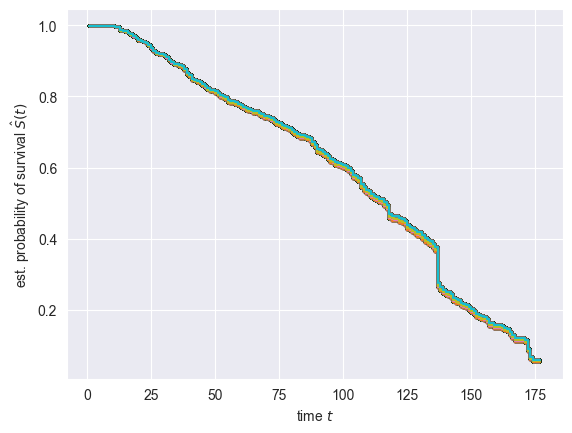

In [93]:
import matplotlib.pyplot as plt
pred_surv = model.predict_survival_function(X)
time_points = np.arange(1, 178)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Edgar dice:
- Le hubiera gustado ver más plots
- No hay estadísticas descriptivas del dataset
- Dejar el seller y el market habría sido interesante para un análisis después del modelo.
- Pareciera que un análisis de clusters sería interesante.
- 